# CUDA Memory Transfer Performance Analysis

This notebook compares pageable (`new[]`) vs pinned (`cudaHostAlloc`) memory transfer performance for GPU operations.

In [1]:
import subprocess
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Compile the program first
print("Compiling compare_mem_access...")
print(os.getcwd())
result = subprocess.run(['make', 'compare_mem_access'],
                       cwd='./')
if result.returncode == 0:
    print("✓ Compilation successful")
else:
    print(f"Error: {result.stderr}")

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Compiling compare_mem_access...
/home/friday/nvme/workspace/ECE455/Proj
Auto-detected GPU with SM 87
Building for ARM (Jetson) with SM 87
/usr/local/cuda/bin/nvcc -O3 -use_fast_math -Xcompiler -Wall -Xcompiler -Wextra -Xcompiler -fopenmp -gencode arch=compute_87,code=sm_87 -c compare_mem_access.cu -o compare_mem_access.o
/usr/local/cuda/bin/nvcc -O3 -use_fast_math -Xcompiler -Wall -Xcompiler -Wextra -Xcompiler -fopenmp -gencode arch=compute_87,code=sm_87 -o compare_mem_access compare_mem_access.o -lgomp
/usr/local/cuda/bin/nvcc -O3 -use_fast_math -Xcompiler -Wall -Xcompiler -Wextra -Xcompiler -fopenmp -gencode arch=compute_87,code=sm_87 -o compare_mem_access compare_mem_access.o -lgomp
✓ Compilation successful
✓ Compilation successful


# Compare memory access: pageable vs. pinned

In [15]:
# Run benchmarks
test_sizes = [64, 128, 256, 512, 1024]
csv_file = './compare_mem_access_output.csv'
num_runs = 5

# Collect data from each run
all_data = []
for size in tqdm(test_sizes, desc="Test sizes", unit="size"):
    for run in tqdm(range(num_runs), desc=f"{size} MB", unit="run"):
        subprocess.run(['./compare_mem_access', str(size)],
                       cwd='./',
                       capture_output=True)
        # Read CSV after each run and accumulate
        run_df = pd.read_csv(csv_file)
        all_data.append(run_df)

# Combine all runs and calculate averages
raw_df = pd.concat(all_data, ignore_index=True)
df = raw_df.groupby(['size_mb', 'memory_type']).mean().reset_index()
print(f"\nCollected {len(raw_df)} measurements, averaged to {len(df)} results")
df

Test sizes: 100%|██████████| 5/5 [00:42<00:00,  8.45s/size]


Collected 75 measurements, averaged to 15 results


,size_mb,memory_type,h2d_ms,h2d_gbps,d2h_ms,d2h_gbps
0,64,Managed,0.050,1314.312,0.414,150.224
1,64,Pageable,12.924,4.834,13.044,4.796
2,64,Pinned,7.846,7.966,7.850,7.962
3,128,Managed,0.048,2694.776,0.832,150.724
4,128,Pageable,24.244,5.154,24.620,5.078
5,128,Pinned,15.664,7.980,15.336,8.158
6,256,Managed,0.050,5187.978,1.656,150.938
7,256,Pageable,47.184,5.298,48.084,5.198
8,256,Pinned,30.298,8.258,15.684,16.360
9,512,Managed,0.050,10593.974,3.384,147.648


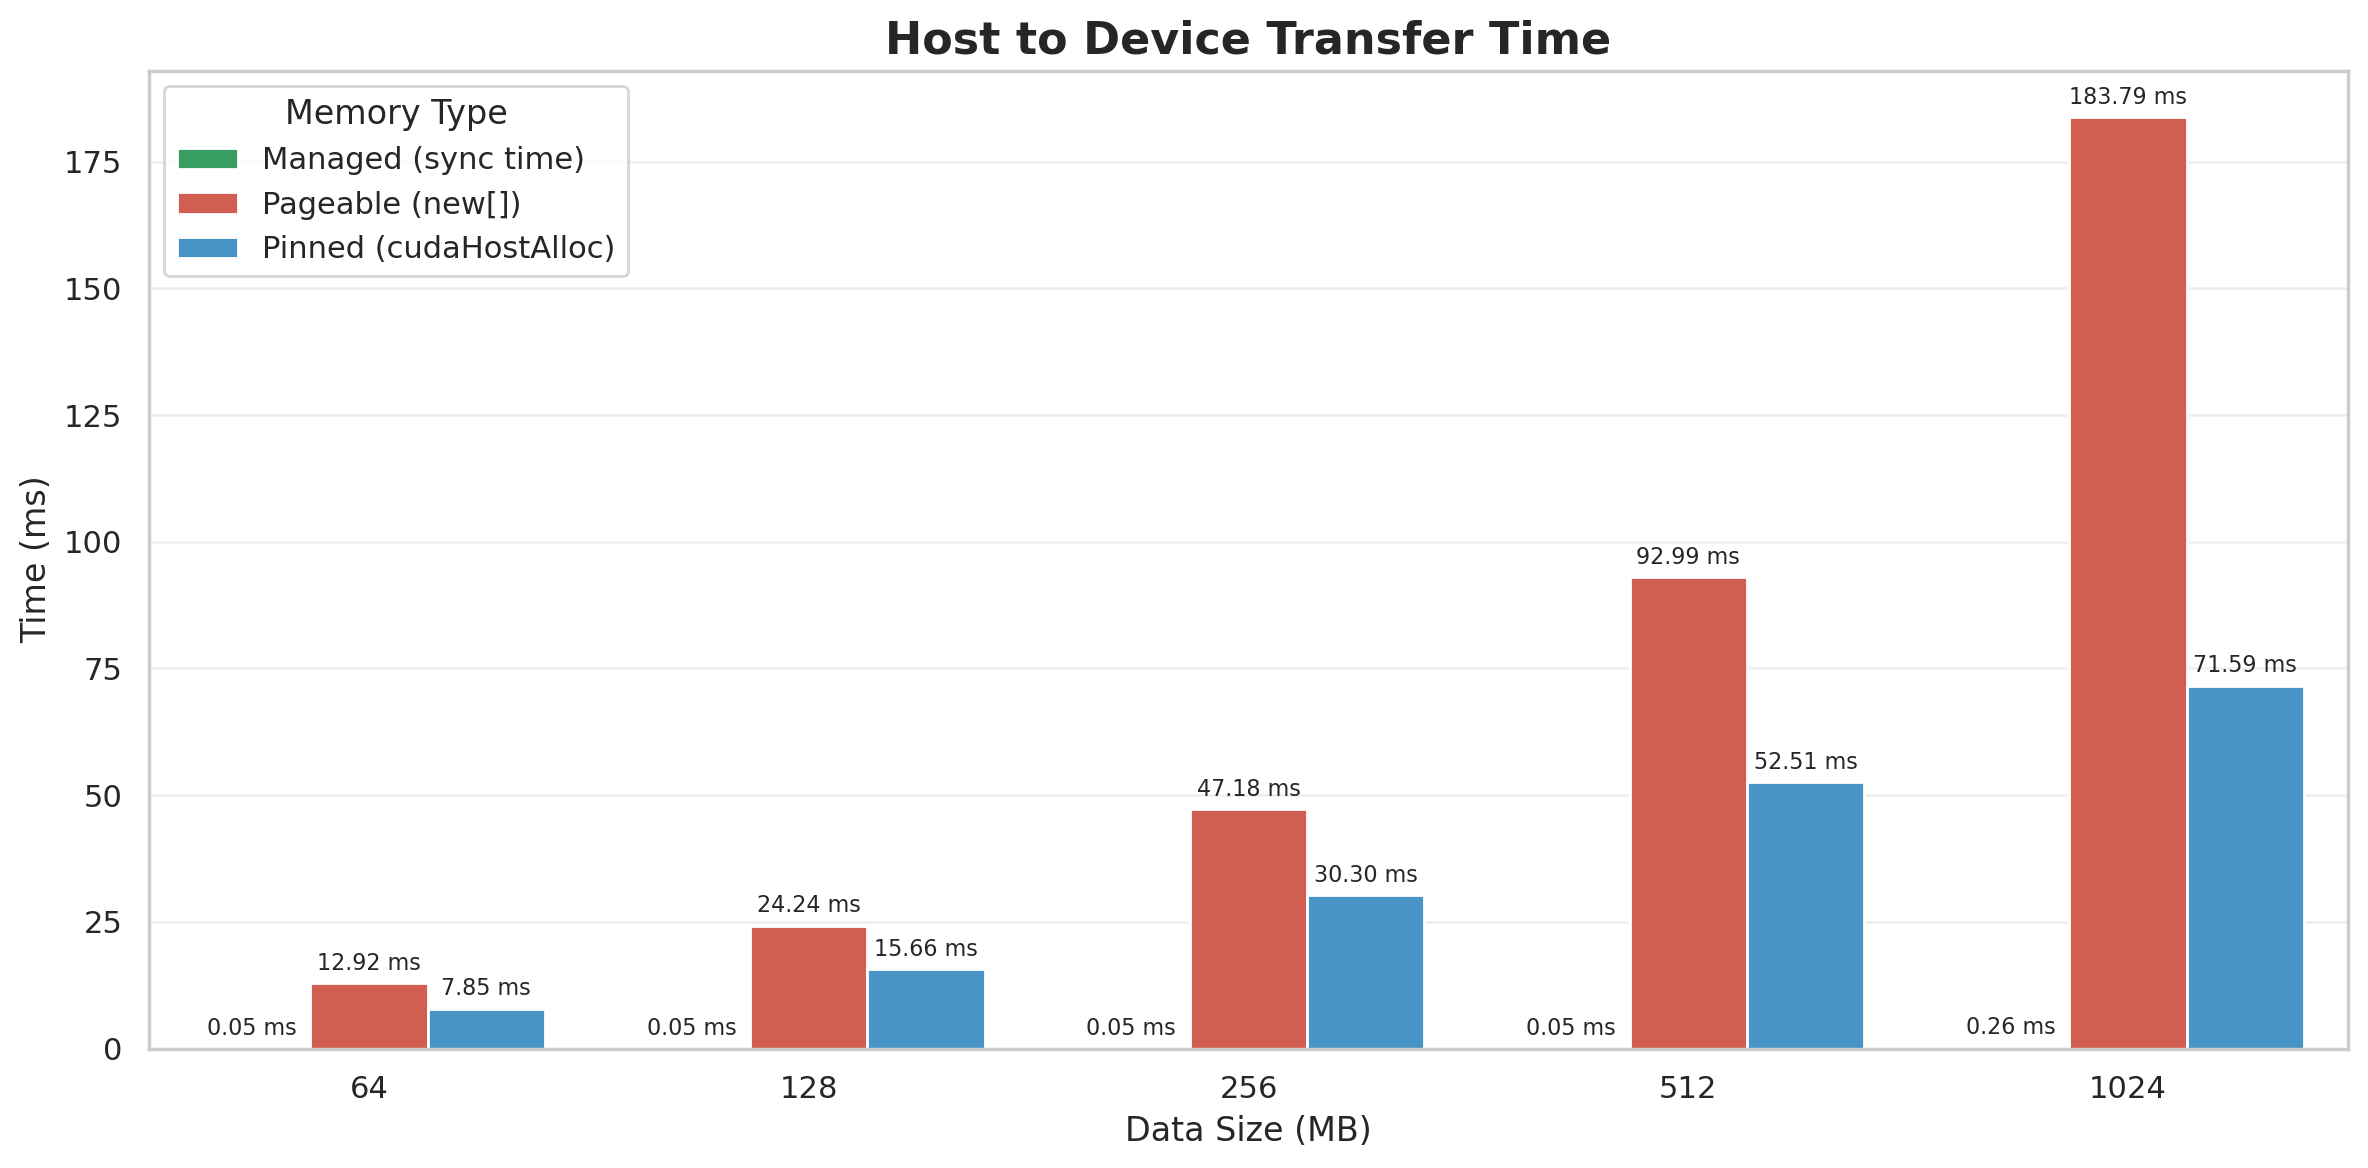

In [28]:
# Host to Device Transfer Time
fig, ax = plt.subplots(figsize=(12, 6) , dpi=200)
sns.barplot(data=df, x='size_mb', y='h2d_ms', hue='memory_type', 
            palette={'Pageable': '#e74c3c', 'Pinned': '#3498db', 'Managed': '#27ae60'}, ax=ax)

plt.title('Host to Device Transfer Time', fontsize=16, fontweight='bold')
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_xlabel('Data Size (MB)', fontsize=12)

# Update legend labels to clarify memory allocation methods
handles, labels = ax.get_legend_handles_labels()
label_map = {
    'Pageable': 'Pageable (new[])',
    'Pinned': 'Pinned (cudaHostAlloc)',
    'Managed': 'Managed (sync time)'
}
labels = [label_map.get(label, label) for label in labels]
ax.legend(handles, labels, title='Memory Type', loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f ms', padding=3, fontsize=8)
plt.tight_layout()
plt.show() 

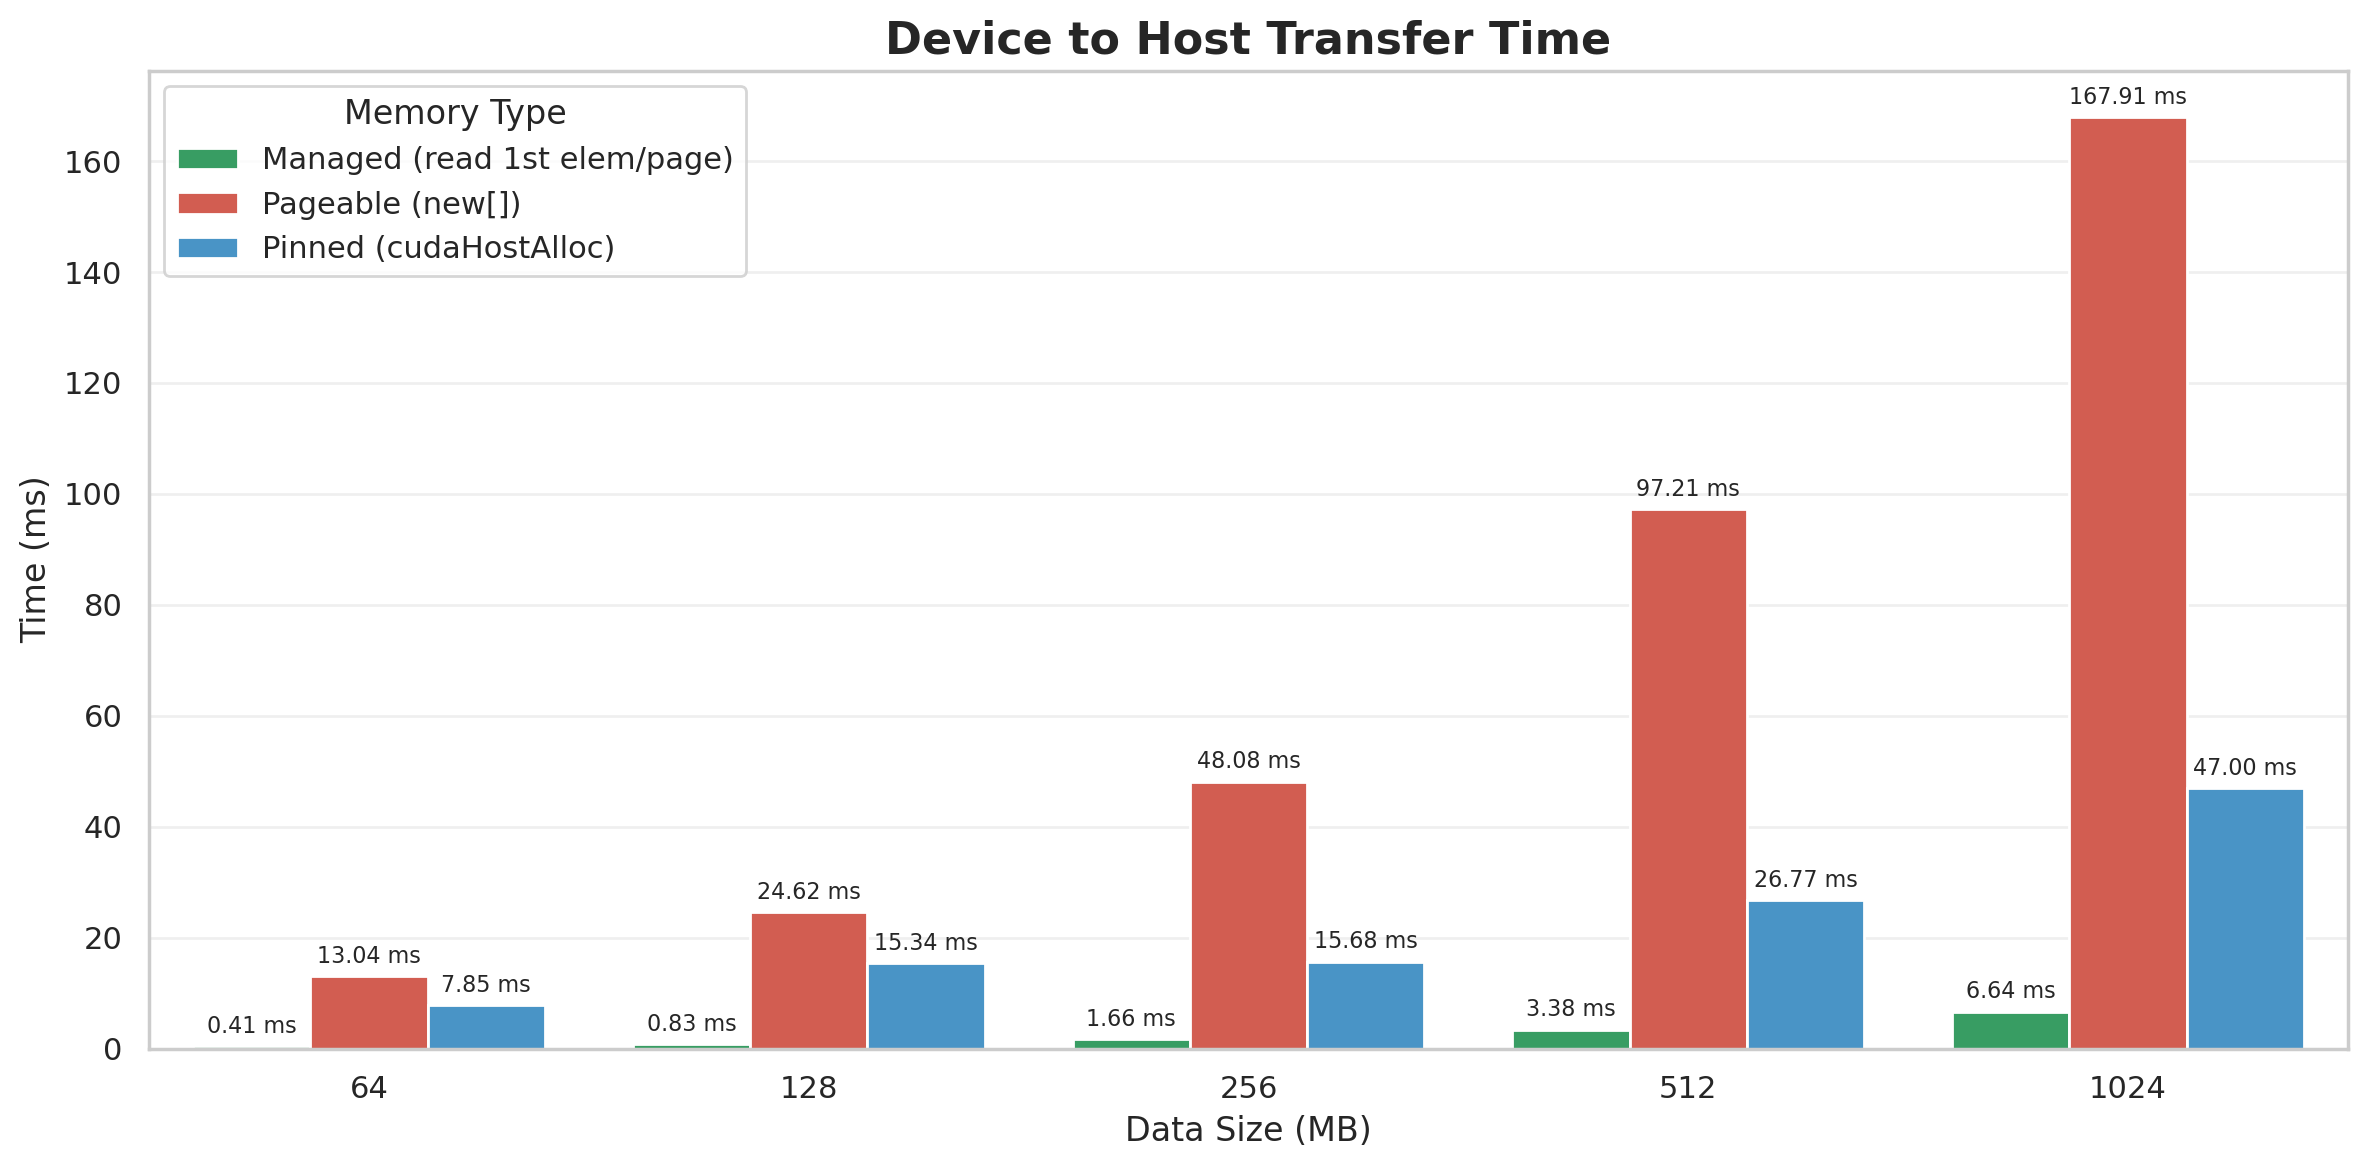

In [27]:
# Device to Host Transfer Time
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
sns.barplot(data=df, x='size_mb', y='d2h_ms', hue='memory_type', 
            palette={'Pageable': '#e74c3c', 'Pinned': '#3498db', 'Managed': '#27ae60'}, ax=ax)

plt.title('Device to Host Transfer Time', fontsize=16, fontweight='bold')
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_xlabel('Data Size (MB)', fontsize=12)

# Update legend labels to clarify memory allocation methods
handles, labels = ax.get_legend_handles_labels()
label_map = {
    'Pageable': 'Pageable (new[])',
    'Pinned': 'Pinned (cudaHostAlloc)',
    'Managed': 'Managed (read 1st elem/page)'
}
labels = [label_map.get(label, label) for label in labels]
ax.legend(handles, labels, title='Memory Type', loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f ms', padding=3, fontsize=8)
    
plt.tight_layout()
plt.show() 

# Compare memory layout: separate vs. combined

# Memory Layout Comparison (Separate vs Combined)

Comparing separate arrays (A, B, C, D) vs combined interleaved memory layout.

In [5]:
# Compile compare_mem_layout
print("Compiling compare_mem_layout...")
result = subprocess.run(['make', 'compare_mem_layout'],
                       cwd='./',
                       capture_output=True, text=True)
if result.returncode == 0:
    print("✓ Compilation successful")
else:
    print(f"Error: {result.stderr}")

Compiling compare_mem_layout...
✓ Compilation successful
✓ Compilation successful


In [6]:
# Run memory layout benchmarks
test_configs = [(100000, 64), (200000, 64), (1000000, 64), (2000000, 64)]
csv_file_layout = './compare_mem_layout_output.csv'
num_runs_layout = 5

# Collect data from each run
all_layout_data = []
for num_matrices, threads in tqdm(test_configs, desc="Test configs", unit="config"):
    for run in tqdm(range(num_runs_layout), desc=f"{num_matrices}×{threads}", leave=False, unit="run"):
        subprocess.run(['./compare_mem_layout', str(num_matrices), str(threads)],
                       cwd='./',
                       capture_output=True)
        # Read CSV after each run and accumulate
        run_df = pd.read_csv(csv_file_layout)
        all_layout_data.append(run_df)

# Combine all runs and calculate averages
raw_layout_df = pd.concat(all_layout_data, ignore_index=True)
layout_df = raw_layout_df.groupby(['num_matrices', 'threads_per_block', 'layout']).mean().reset_index()
print(f"\nCollected {len(raw_layout_df)} measurements, averaged to {len(layout_df)} results")
layout_df

Test configs: 100%|██████████| 4/4 [01:11<00:00, 17.86s/config]


Collected 80 measurements, averaged to 16 results


,num_matrices,threads_per_block,layout,cpu_ms,omp_ms,gpu_ms,gpu_xfer_ms,gpu_total_ms,cpu_gflops,omp_gflops,gpu_gflops,speedup
0,100000,64,Combined (Managed),6.5280,2.9980,4.3240,0.000,4.3240,5.88,13.18,8.90,1.510
1,100000,64,Combined (Pinned),8.0140,3.1900,3.8180,4.052,7.8700,4.80,12.22,10.06,1.018
2,100000,64,Separate (Managed),4.8376,3.3732,5.6208,0.000,5.6208,7.94,11.50,7.94,1.006
3,100000,64,Separate (Pinned),4.8320,2.3640,3.1280,4.054,7.1820,7.96,16.30,12.28,0.672
4,200000,64,Combined (Managed),12.8220,6.2840,7.5120,0.000,7.5120,5.98,12.70,10.24,1.708
5,200000,64,Combined (Pinned),15.0840,5.7400,6.8920,7.662,14.5520,5.10,13.42,11.14,1.038
6,200000,64,Separate (Managed),9.8942,7.8000,7.2716,0.000,7.2716,7.76,12.98,10.56,1.362
7,200000,64,Separate (Pinned),9.7900,5.6580,5.5240,7.770,13.2980,7.86,15.30,13.92,0.736
8,1000000,64,Combined (Managed),73.1900,22.4220,34.8220,0.000,34.8220,5.24,17.16,11.02,2.102
9,1000000,64,Combined (Pinned),72.9440,24.9560,22.9820,33.164,56.1420,5.24,15.40,17.40,1.308


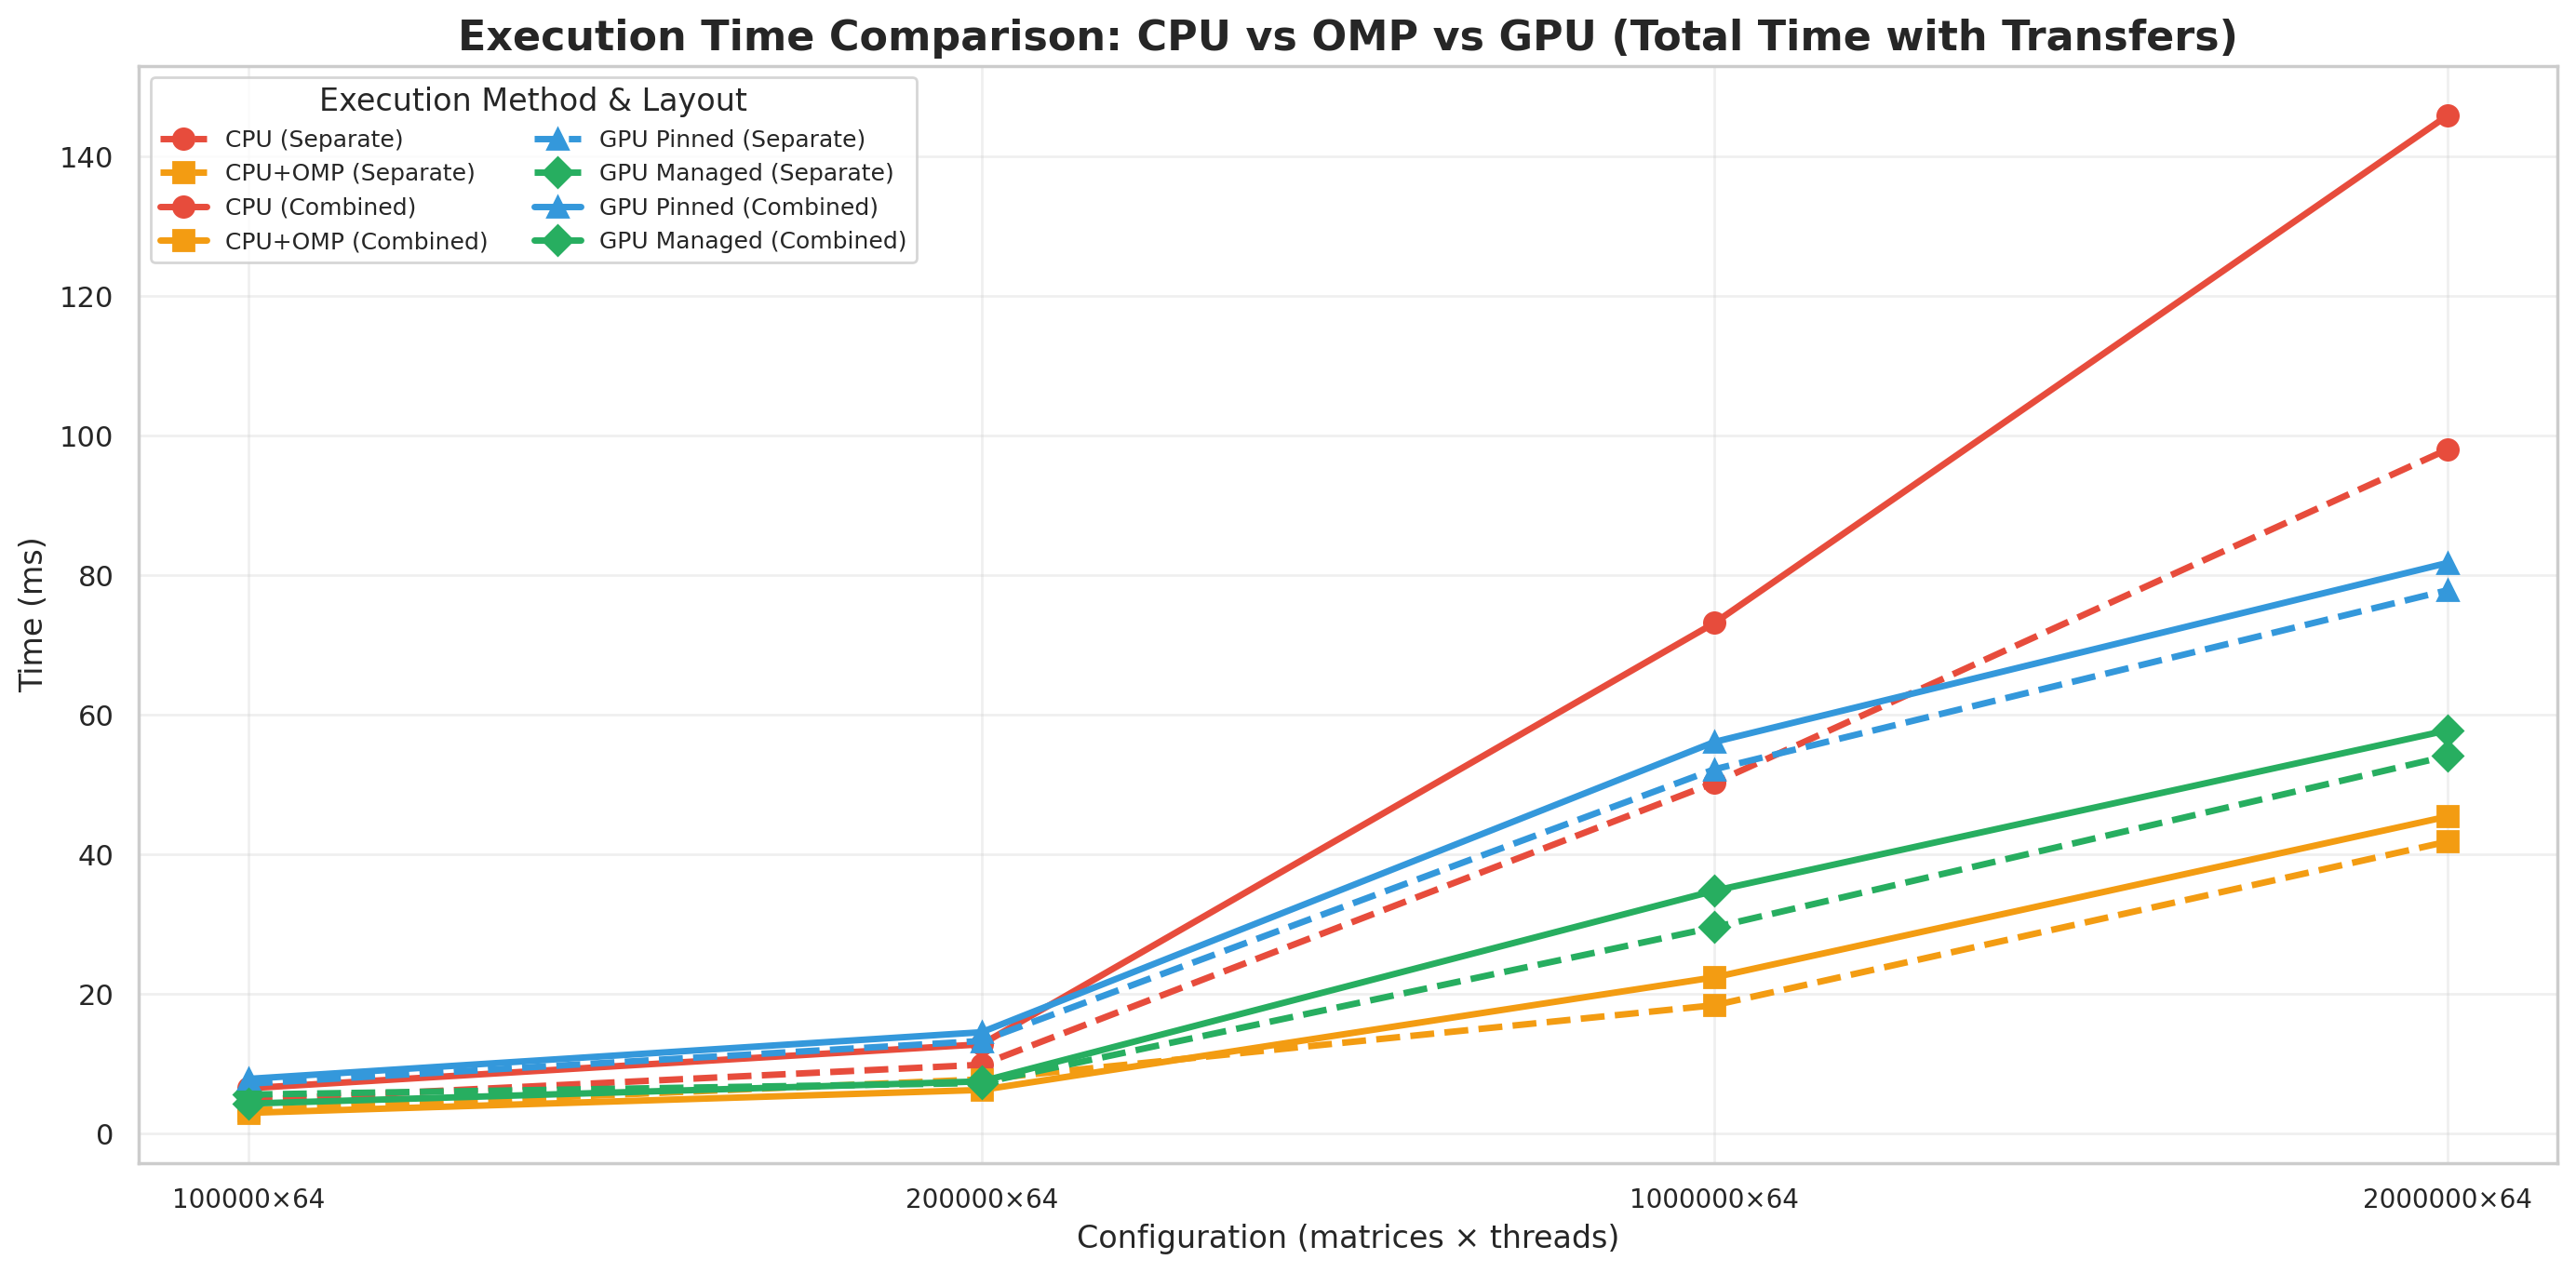

In [7]:
# Execution Time Comparison: Line plot with layout distinction
fig, ax = plt.subplots(figsize=(14, 7), dpi=200)

# Create config column first
layout_df['config'] = layout_df['num_matrices'].astype(str) + '×' + layout_df['threads_per_block'].astype(str)

# Get unique configs and sort by num_matrices
unique_configs = layout_df[['config', 'num_matrices']].drop_duplicates().sort_values('num_matrices')
config_order = unique_configs['config'].tolist()

# Check if we have managed memory data
has_managed = any('Managed' in str(layout) for layout in layout_df['layout'].unique())

# Define colors for different execution methods
colors = {
    'CPU': '#e74c3c',
    'CPU+OMP': '#f39c12',
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Separate data by layout type
separate_df = layout_df[layout_df['layout'].str.contains('Separate', case=False)]
combined_df = layout_df[layout_df['layout'].str.contains('Combined', case=False)]

# Plot CPU (same for both managed and pinned within same layout)
for layout_type, df, linestyle in [('Separate', separate_df, '--'), ('Combined', combined_df, '-')]:
    if len(df) == 0:
        continue
    
    # Group by config to get unique CPU/OMP values (they're same for managed/pinned)
    df_grouped = df.groupby('config').first().reindex(config_order)
    x_pos = range(len(config_order))
    
    # CPU
    ax.plot(x_pos, df_grouped['cpu_ms'], linestyle=linestyle, linewidth=2.5, 
            marker='o', markersize=8, color=colors['CPU'], 
            label=f'CPU ({layout_type})')
    
    # CPU+OMP
    ax.plot(x_pos, df_grouped['omp_ms'], linestyle=linestyle, linewidth=2.5,
            marker='s', markersize=8, color=colors['CPU+OMP'],
            label=f'CPU+OMP ({layout_type})')

# Plot GPU data - separate lines for Pinned and Managed
for layout_type, df, linestyle in [('Separate', separate_df, '--'), ('Combined', combined_df, '-')]:
    if len(df) == 0:
        continue
    
    # GPU Pinned
    pinned_df = df[df['layout'].str.contains('Pinned', case=False)]
    if len(pinned_df) > 0:
        pinned_grouped = pinned_df.set_index('config').reindex(config_order)
        x_pos = range(len(config_order))
        ax.plot(x_pos, pinned_grouped['gpu_total_ms'], linestyle=linestyle, linewidth=2.5,
                marker='^', markersize=8, color=colors['GPU (Pinned)'],
                label=f'GPU Pinned ({layout_type})')
    
    # GPU Managed (only if available)
    if has_managed:
        managed_df = df[df['layout'].str.contains('Managed', case=False)]
        if len(managed_df) > 0:
            managed_grouped = managed_df.set_index('config').reindex(config_order)
            ax.plot(x_pos, managed_grouped['gpu_total_ms'], linestyle=linestyle, linewidth=2.5,
                    marker='D', markersize=8, color=colors['GPU (Managed)'],
                    label=f'GPU Managed ({layout_type})')

plt.title('Execution Time Comparison: CPU vs OMP vs GPU (Total Time with Transfers)', 
          fontsize=16, fontweight='bold')
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_xlabel('Configuration (matrices × threads)', fontsize=12)
ax.set_xticks(range(len(config_order)))
ax.set_xticklabels(config_order, fontsize=10)
ax.legend(title='Execution Method & Layout', loc='best', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare variable joints

# Variable Joints Benchmark Analysis

Analyzing the performance impact of chain length (number of joints) on matrix multiplication.

In [8]:
# Compile and run variable joints benchmark
print("Compiling compare_variable_joints...")
result = subprocess.run(['make', 'compare_variable_joints'],
                       cwd='./',
                       capture_output=True, text=True)
if result.returncode == 0:
    print("✓ Compilation successful")
else:
    print(f"Error: {result.stderr}")

Compiling compare_variable_joints...
✓ Compilation successful
✓ Compilation successful


In [9]:
# Run variable joints benchmark with multiple runs and averaging
csv_file_joints = './compare_variable_joints_output.csv'
num_runs_joints = 5

# Collect data from each run
all_joints_data = []
for run in tqdm(range(num_runs_joints), desc="Variable joints runs", unit="run"):
    subprocess.run(['./compare_variable_joints', '500000', '64'],
                   cwd='./',
                   capture_output=True)
    # Read CSV after each run and accumulate
    run_df = pd.read_csv(csv_file_joints)
    all_joints_data.append(run_df)

# Combine all runs and calculate averages
raw_joints_df = pd.concat(all_joints_data, ignore_index=True)
joints_df = raw_joints_df.groupby(['num_joints', 'memory_type']).mean().reset_index()
print(f"\nCollected {len(raw_joints_df)} measurements, averaged to {len(joints_df)} results")
joints_df

Variable joints runs: 100%|██████████| 5/5 [04:03<00:00, 48.79s/run]


Collected 160 measurements, averaged to 32 results


,num_joints,memory_type,num_ops,threads_per_block,cpu_ms,omp_ms,gpu_kernel_ms,transfer_ms,total_ms,cpu_gflops,omp_gflops,gpu_gflops,speedup,correct
0,2,Managed,500000.0,64.0,20.5320,9.9474,13.5840,0.0000,13.5840,3.122,6.512,4.716,1.514,1.0
1,2,Pinned,500000.0,64.0,16.9426,4.8766,11.4430,11.3704,22.8134,3.822,13.204,5.594,0.744,1.0
2,4,Managed,500000.0,64.0,36.8508,12.0192,17.8396,0.0000,17.8396,5.210,16.142,10.762,2.066,1.0
3,4,Pinned,500000.0,64.0,31.8810,9.3618,15.8552,18.7520,34.6072,6.024,20.574,12.108,0.920,1.0
4,6,Managed,500000.0,64.0,52.1496,20.7580,25.2694,0.0000,25.2694,6.144,15.716,12.662,2.064,1.0
5,6,Pinned,500000.0,64.0,50.6982,16.2326,21.1090,24.8758,45.9848,6.312,19.730,15.212,1.104,1.0
6,8,Managed,500000.0,64.0,69.4566,24.1854,32.2750,0.0000,32.2750,6.448,19.004,13.882,2.150,1.0
7,8,Pinned,500000.0,64.0,69.5692,21.9944,21.1762,31.4700,52.6462,6.440,20.380,21.544,1.324,1.0
8,10,Managed,500000.0,64.0,88.2892,28.7968,40.0324,0.0000,40.0324,6.524,20.088,14.388,2.206,1.0
9,10,Pinned,500000.0,64.0,88.4252,30.5292,20.4484,38.7052,59.1536,6.514,19.172,29.186,1.502,1.0


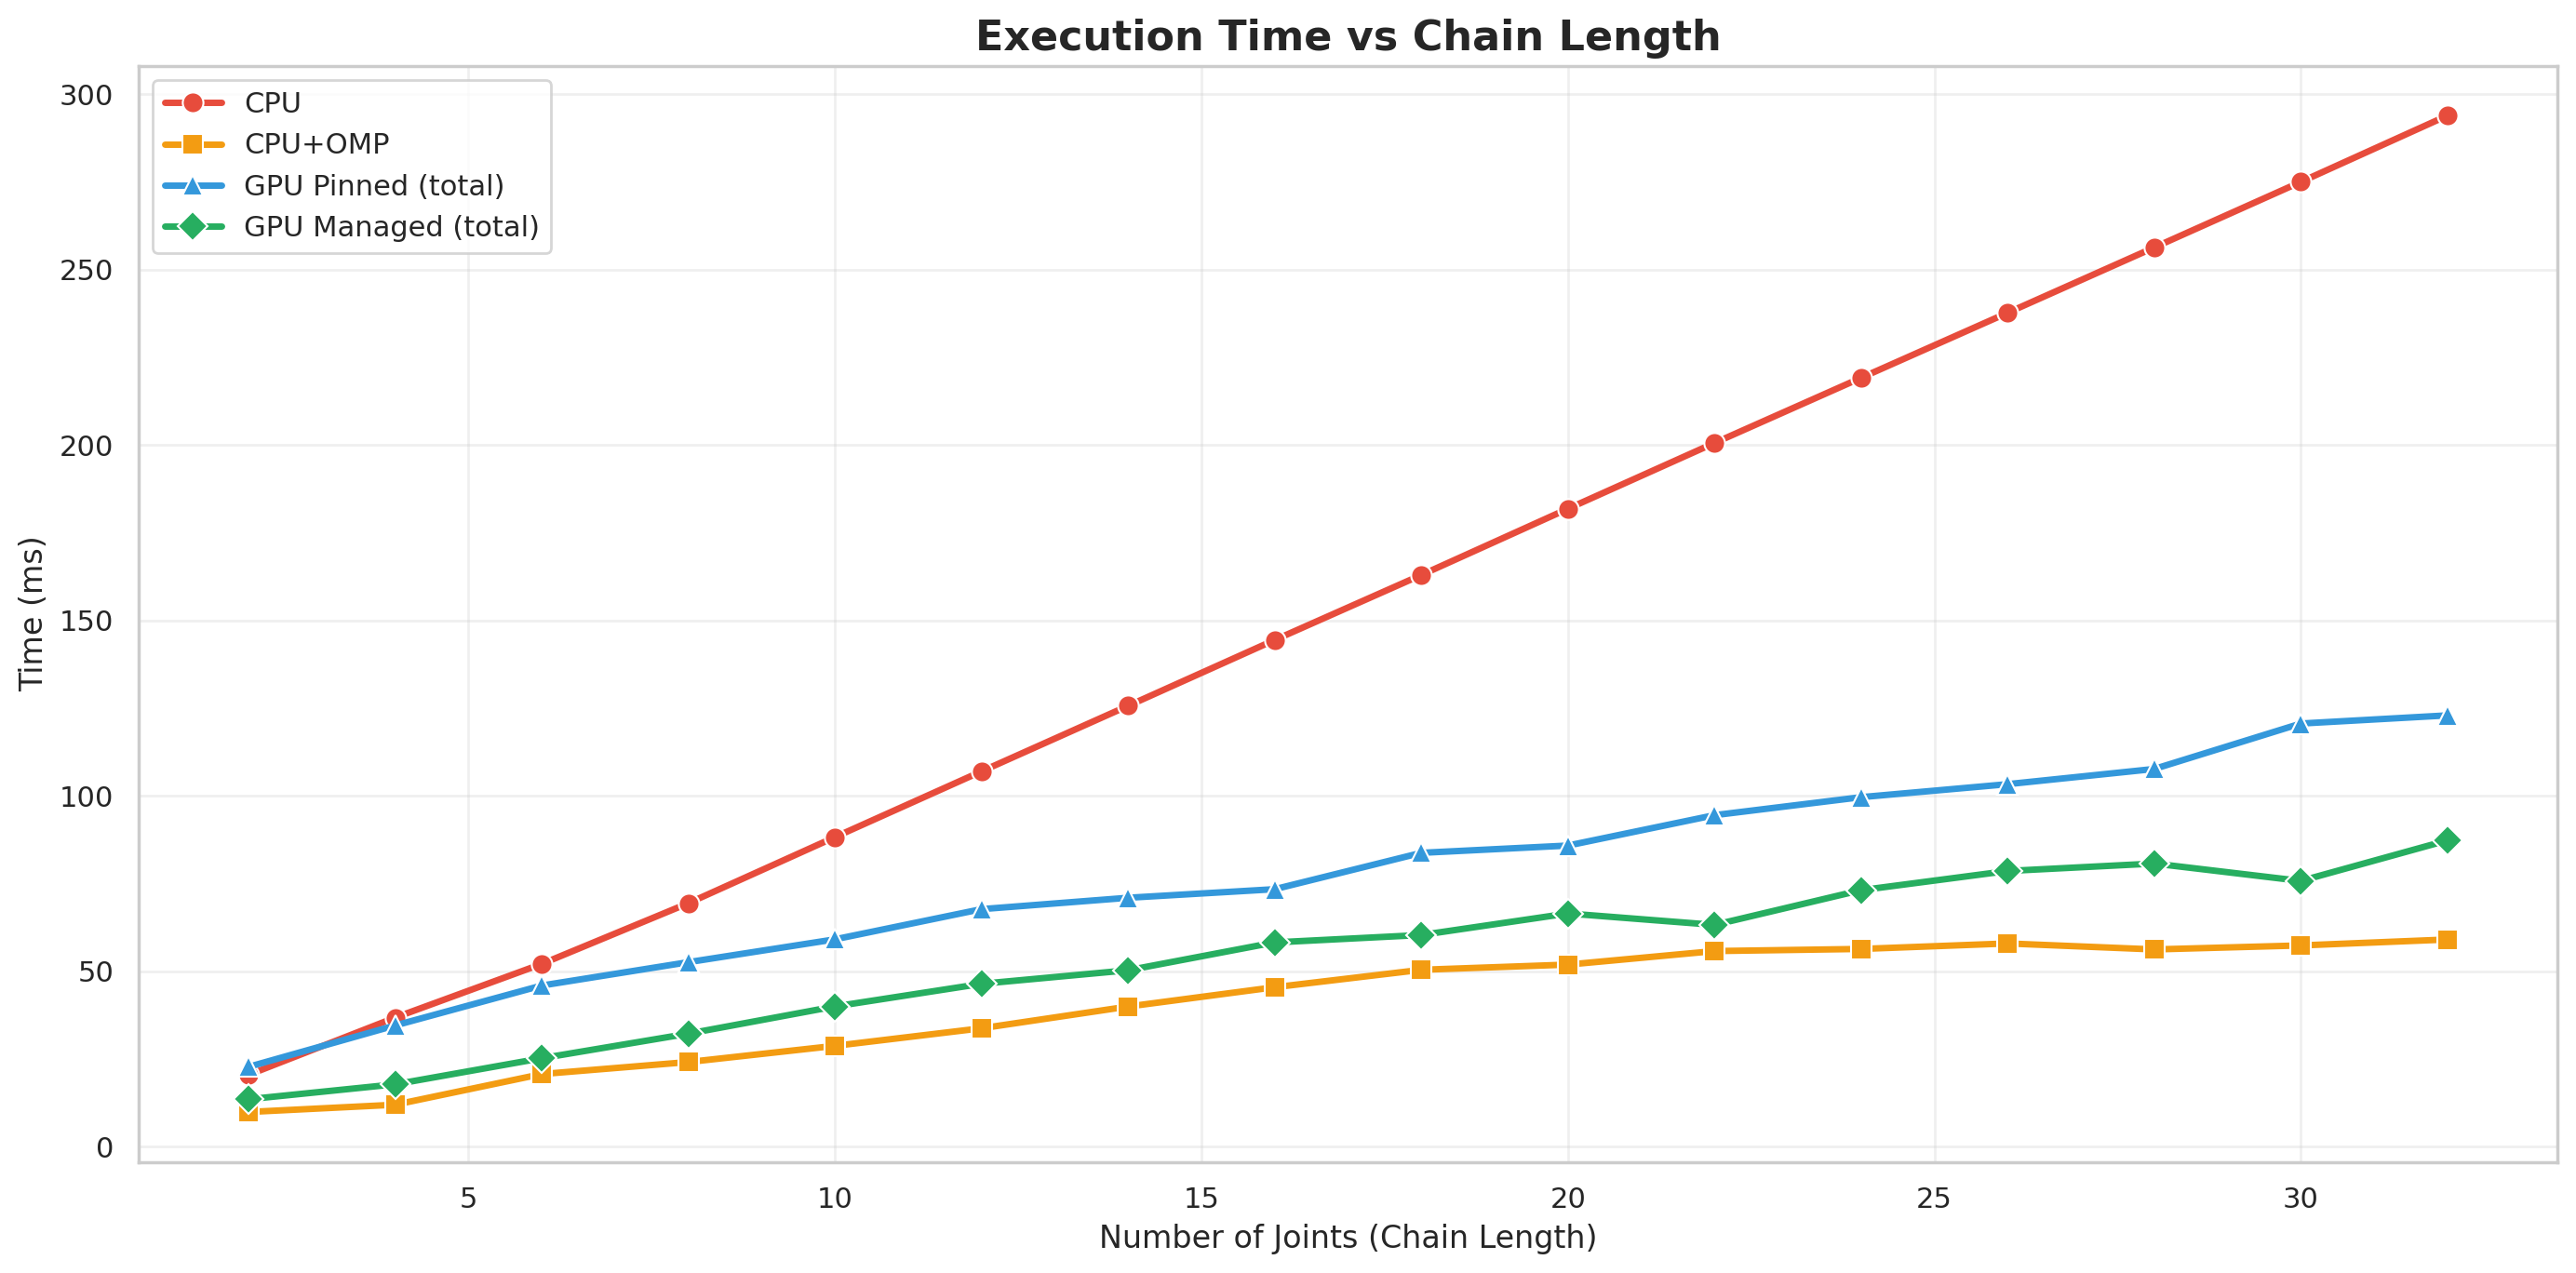

In [10]:
# Execution time vs chain length
fig, ax = plt.subplots(figsize=(14, 7), dpi=200)

# Check if we have managed memory data
has_managed = 'Managed' in joints_df['memory_type'].values

# Define colors
colors = {
    'CPU': '#e74c3c',
    'CPU+OMP': '#f39c12',
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Get CPU/OMP data (same for both memory types, so just take first occurrence per num_joints)
cpu_omp_df = joints_df.groupby('num_joints').first().reset_index()

# Plot CPU and CPU+OMP (same regardless of memory type)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='cpu_ms', marker='o', linewidth=2.5, 
             markersize=8, label='CPU', color=colors['CPU'], ax=ax)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='omp_ms', marker='s', linewidth=2.5, 
             markersize=8, label='CPU+OMP', color=colors['CPU+OMP'], ax=ax)

# Plot GPU Pinned (always present)
pinned_df = joints_df[joints_df['memory_type'] == 'Pinned']
if len(pinned_df) > 0:
    sns.lineplot(data=pinned_df, x='num_joints', y='total_ms', marker='^', linewidth=2.5, 
                 markersize=8, label='GPU Pinned (total)', color=colors['GPU (Pinned)'], ax=ax)

# Plot GPU Managed (only if available)
if has_managed:
    managed_df = joints_df[joints_df['memory_type'] == 'Managed']
    if len(managed_df) > 0:
        sns.lineplot(data=managed_df, x='num_joints', y='total_ms', marker='D', linewidth=2.5, 
                     markersize=8, label='GPU Managed (total)', color=colors['GPU (Managed)'], ax=ax)

plt.title('Execution Time vs Chain Length', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Time (ms)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

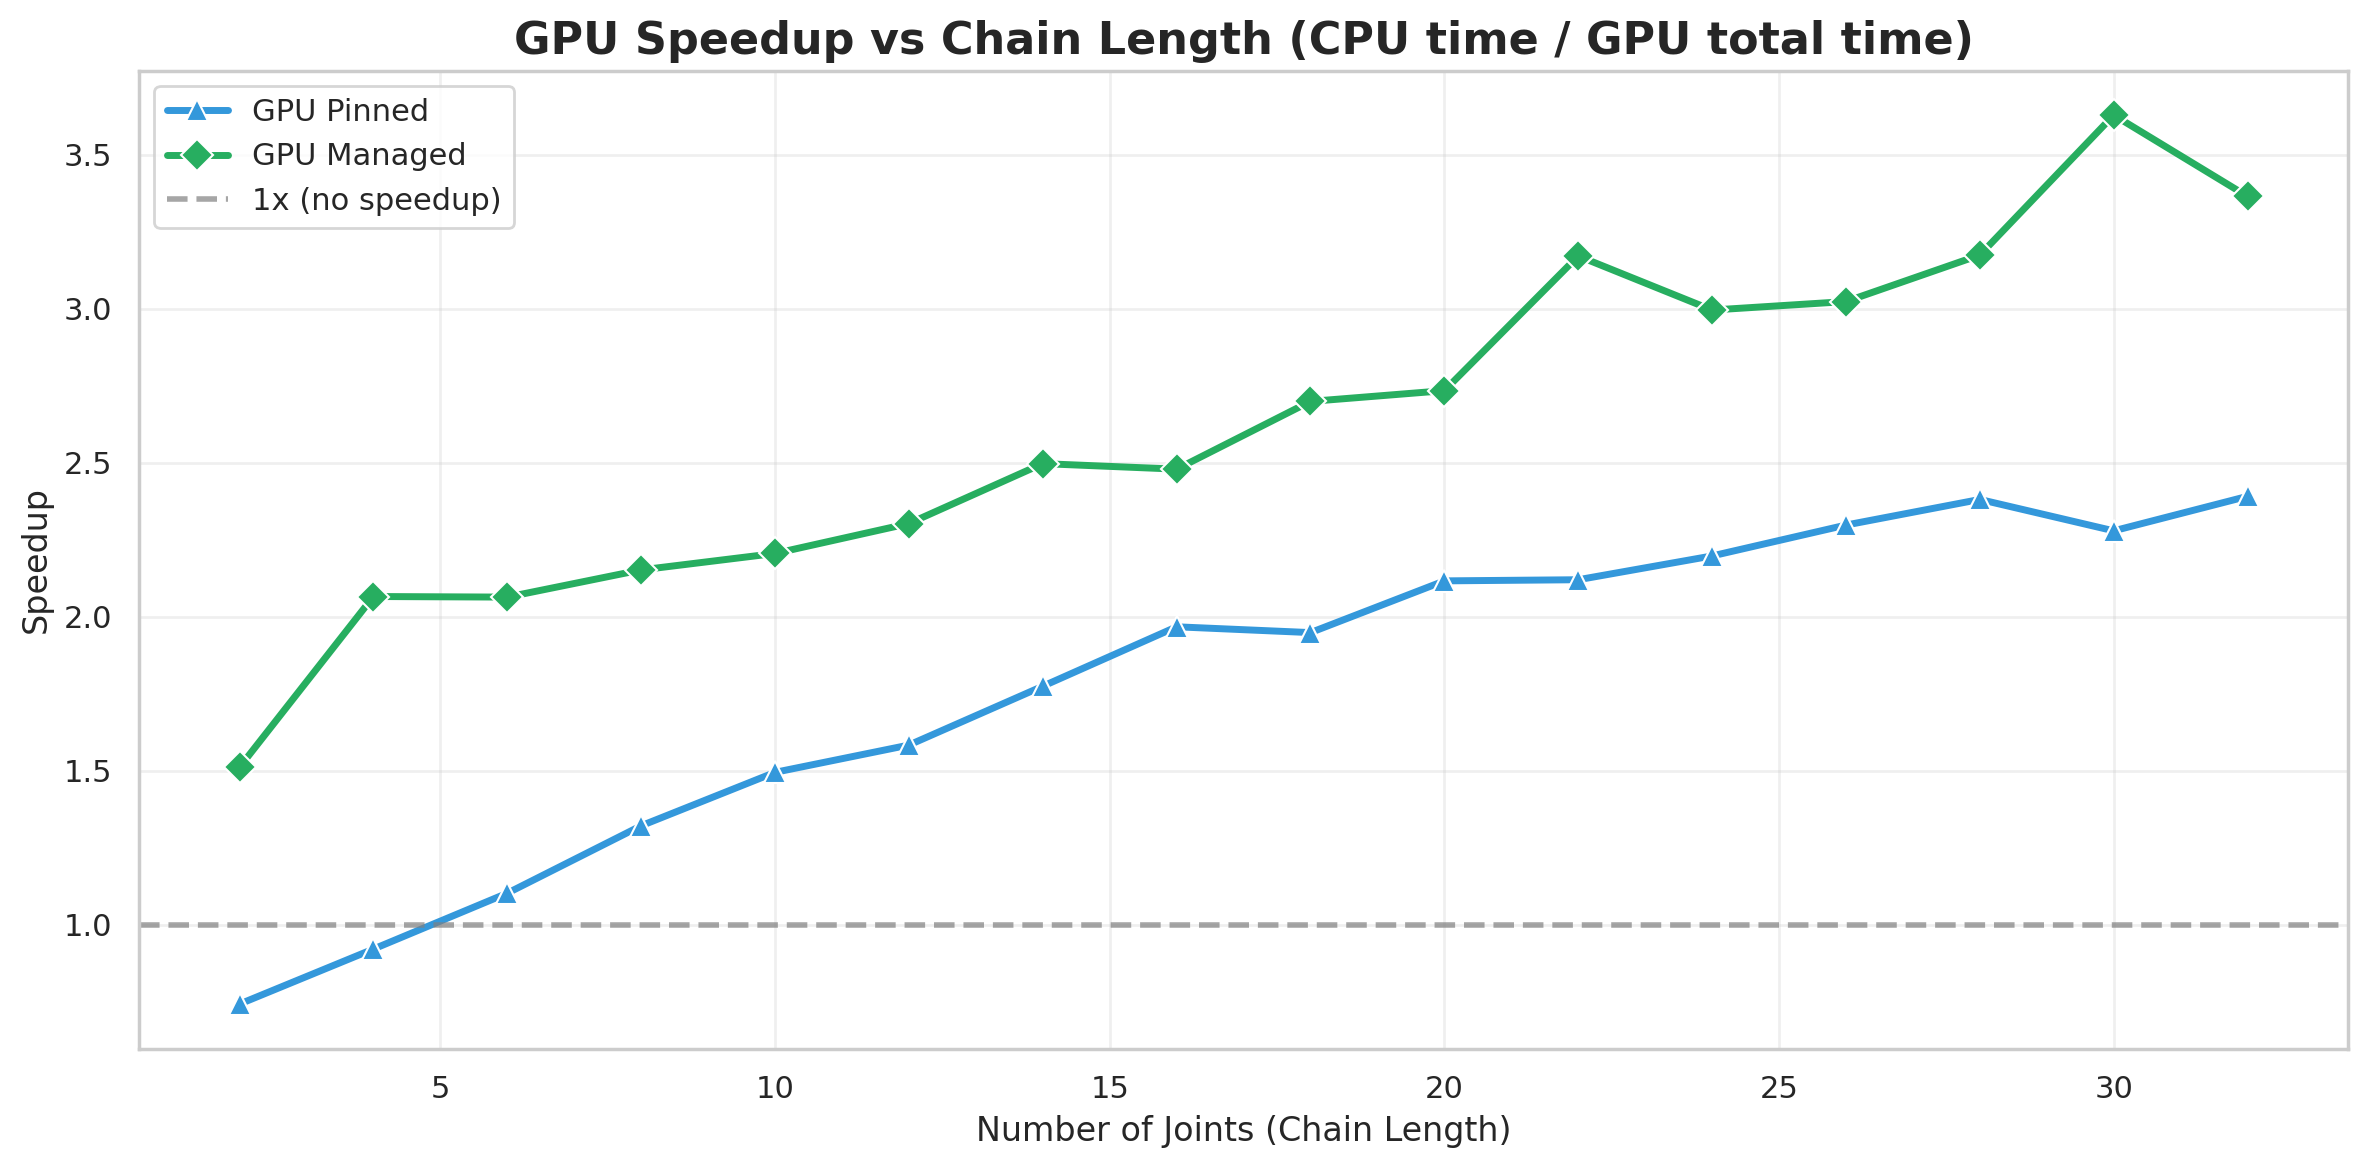

In [11]:
# GPU Speedup vs chain length
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# Check if we have managed memory data
has_managed = 'Managed' in joints_df['memory_type'].values

# Calculate speedup for each memory type
joints_df['speedup_vs_cpu'] = joints_df['cpu_ms'] / joints_df['total_ms']

# Define colors
colors = {
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Plot GPU Pinned speedup
pinned_df = joints_df[joints_df['memory_type'] == 'Pinned']
if len(pinned_df) > 0:
    sns.lineplot(data=pinned_df, x='num_joints', y='speedup_vs_cpu', marker='^', 
                 linewidth=2.5, markersize=8, color=colors['GPU (Pinned)'], 
                 label='GPU Pinned', ax=ax)

# Plot GPU Managed speedup (only if available)
if has_managed:
    managed_df = joints_df[joints_df['memory_type'] == 'Managed']
    if len(managed_df) > 0:
        sns.lineplot(data=managed_df, x='num_joints', y='speedup_vs_cpu', marker='D', 
                     linewidth=2.5, markersize=8, color=colors['GPU (Managed)'], 
                     label='GPU Managed', ax=ax)

# Add horizontal line at 1x speedup
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='1x (no speedup)')

plt.title('GPU Speedup vs Chain Length (CPU time / GPU total time)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

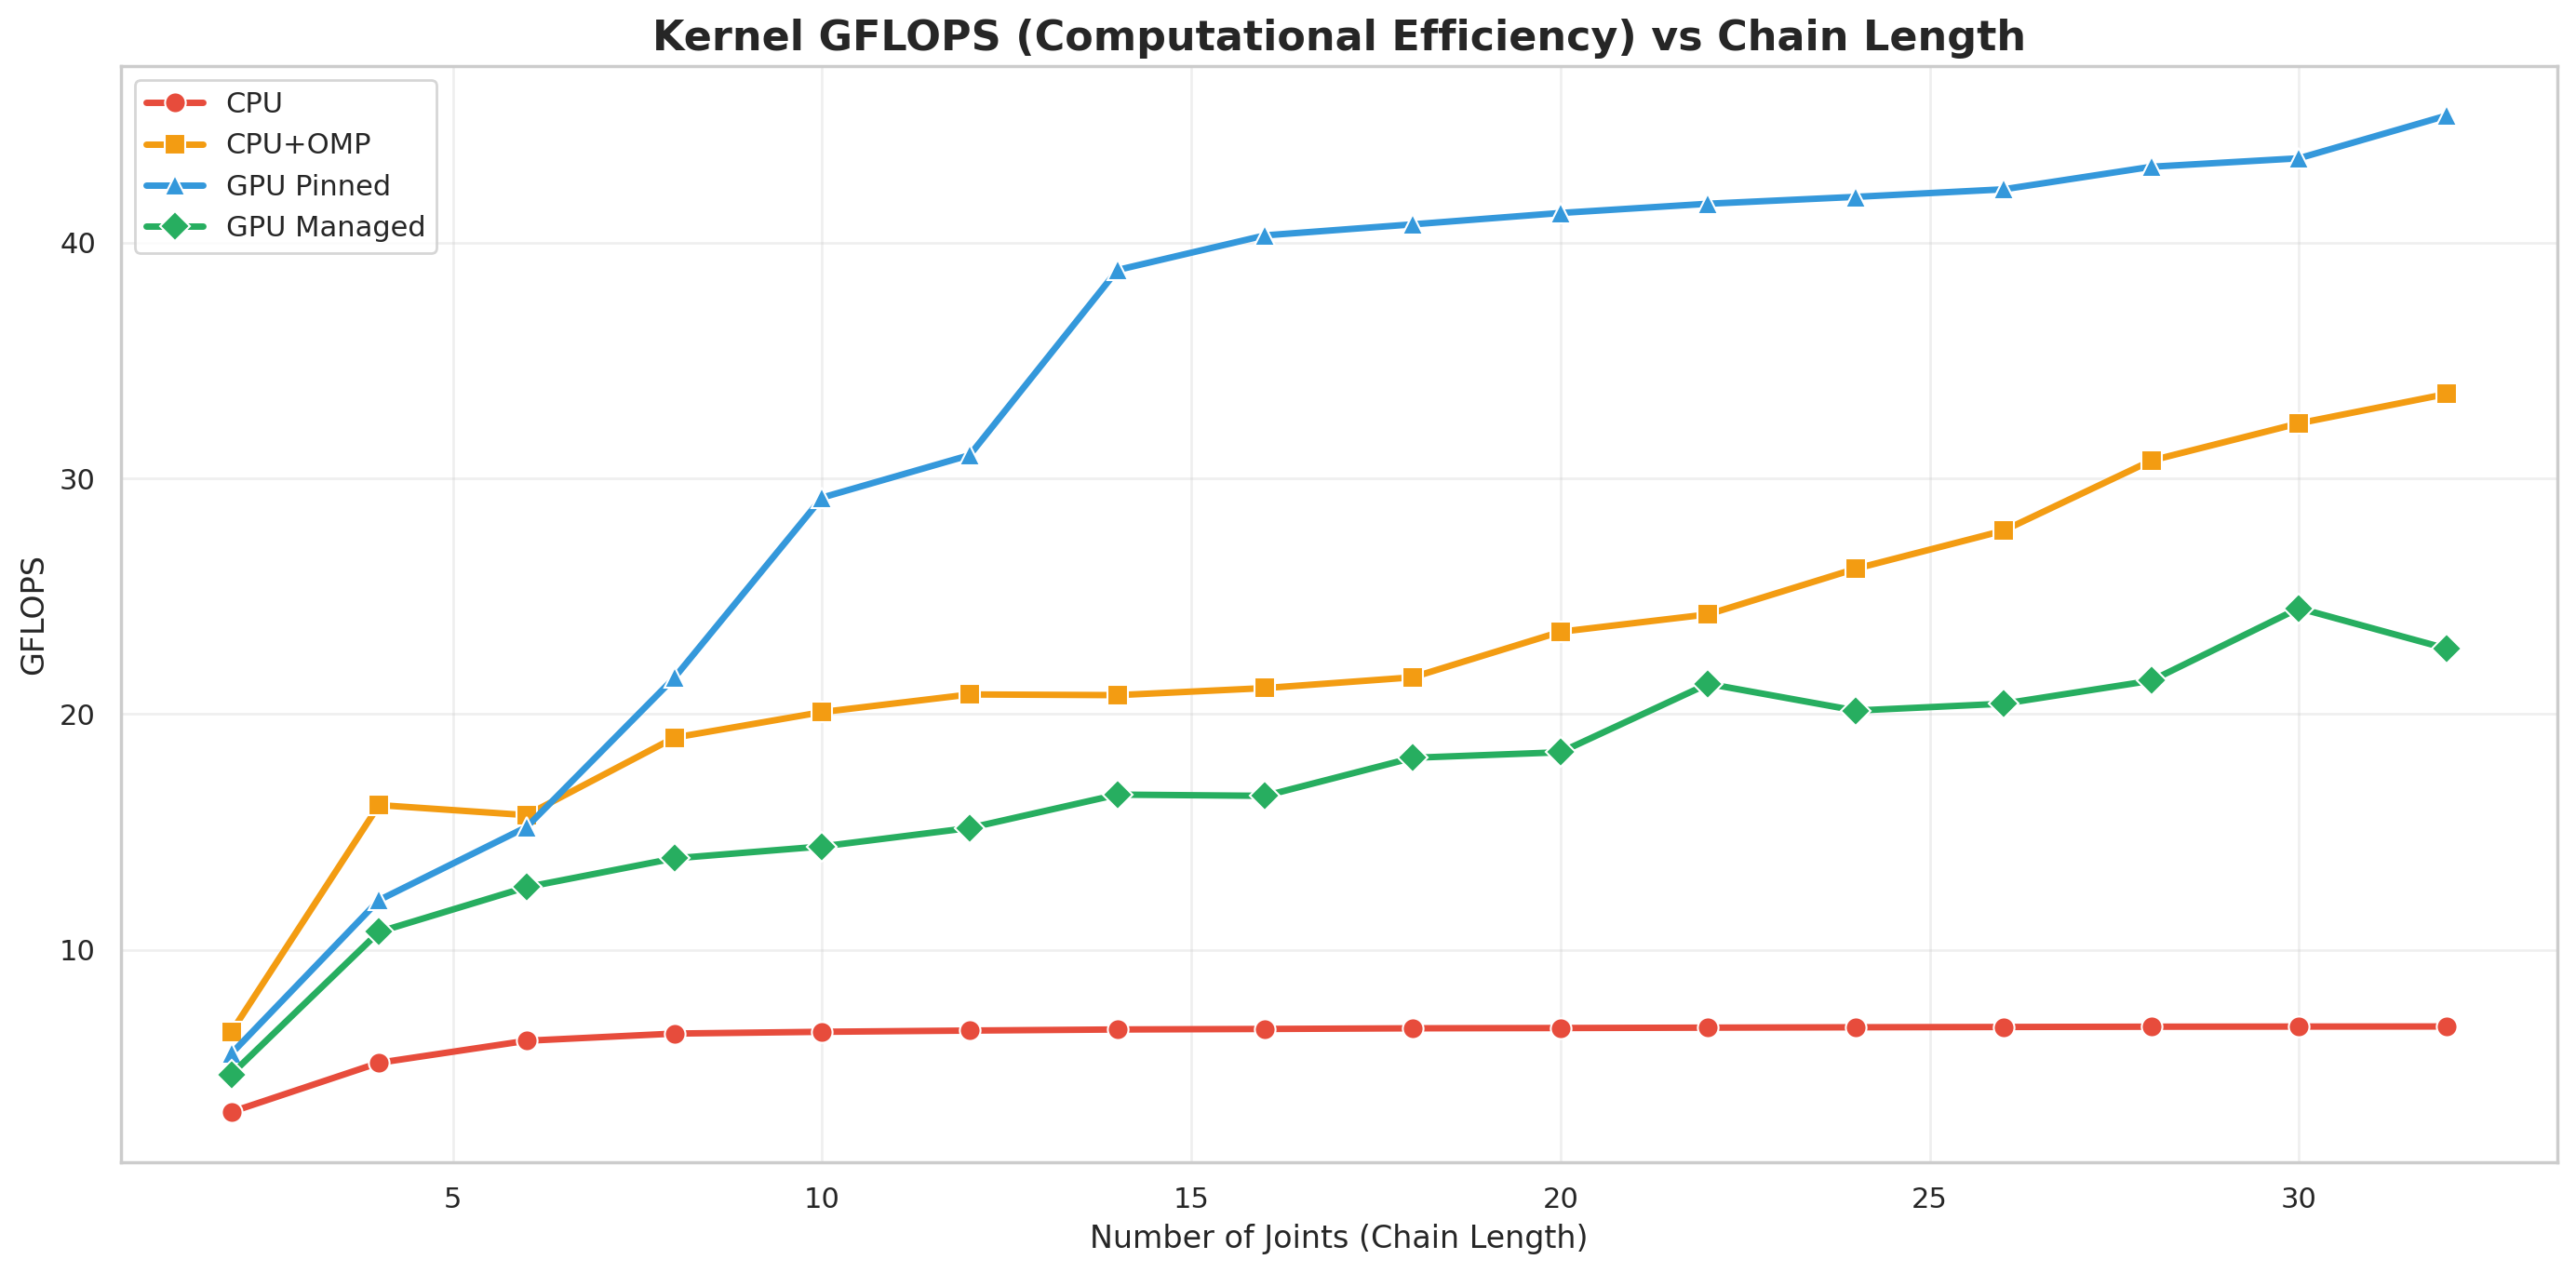

In [12]:
# GFLOPS comparison showing efficiency
fig, ax = plt.subplots(figsize=(14, 7), dpi=200)

# Check if we have managed memory data
has_managed = 'Managed' in joints_df['memory_type'].values

# Define colors
colors = {
    'CPU': '#e74c3c',
    'CPU+OMP': '#f39c12',
    'GPU (Pinned)': '#3498db',
    'GPU (Managed)': '#27ae60'
}

# Get CPU/OMP data (same for both memory types, so just take first occurrence per num_joints)
cpu_omp_df = joints_df.groupby('num_joints').first().reset_index()

# Plot CPU and CPU+OMP (same regardless of memory type)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='cpu_gflops', marker='o', linewidth=2.5, 
             markersize=8, label='CPU', color=colors['CPU'], ax=ax)
sns.lineplot(data=cpu_omp_df, x='num_joints', y='omp_gflops', marker='s', linewidth=2.5, 
             markersize=8, label='CPU+OMP', color=colors['CPU+OMP'], ax=ax)

# Plot GPU Pinned GFLOPS
pinned_df = joints_df[joints_df['memory_type'] == 'Pinned']
if len(pinned_df) > 0:
    sns.lineplot(data=pinned_df, x='num_joints', y='gpu_gflops', marker='^', linewidth=2.5, 
                 markersize=8, label='GPU Pinned', color=colors['GPU (Pinned)'], ax=ax)

# Plot GPU Managed GFLOPS (only if available)
if has_managed:
    managed_df = joints_df[joints_df['memory_type'] == 'Managed']
    if len(managed_df) > 0:
        sns.lineplot(data=managed_df, x='num_joints', y='gpu_gflops', marker='D', linewidth=2.5, 
                     markersize=8, label='GPU Managed', color=colors['GPU (Managed)'], ax=ax)

plt.title('Kernel GFLOPS (Computational Efficiency) vs Chain Length', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('GFLOPS', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

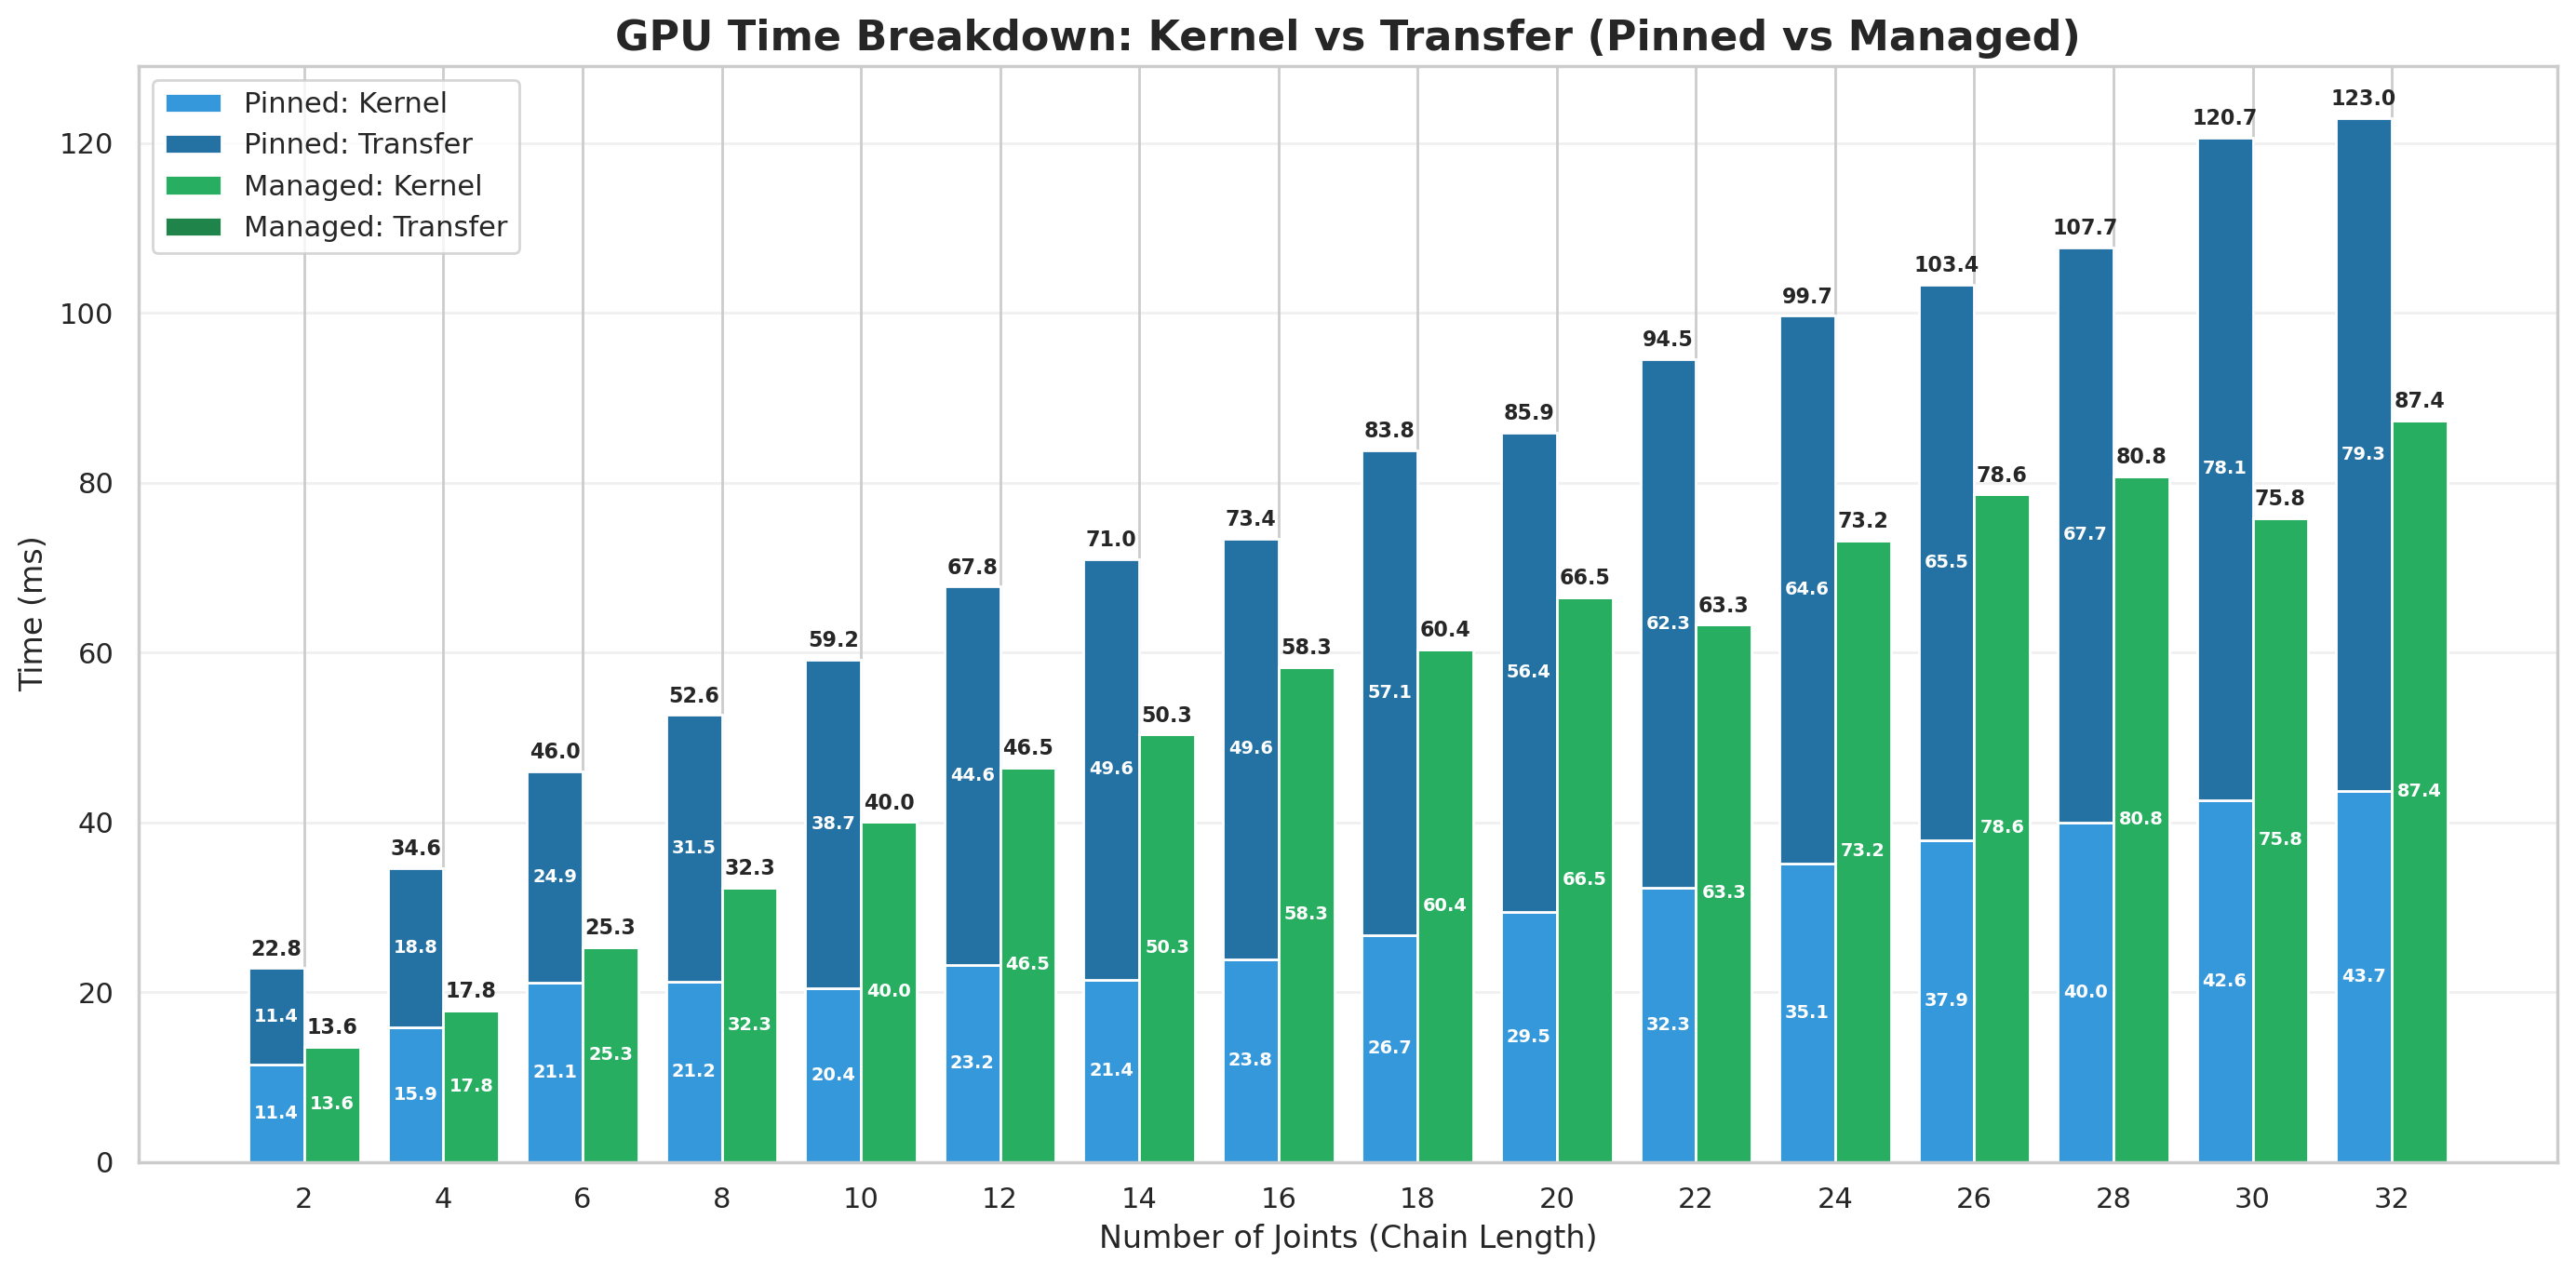

In [13]:
# Transfer vs kernel time breakdown - Pinned and Managed side by side
fig, ax = plt.subplots(figsize=(14, 7), dpi=200)

# Check if we have managed memory data
has_managed = 'Managed' in joints_df['memory_type'].values

# Define colors
pinned_kernel_color = '#3498db'
pinned_transfer_color = '#2471a3'
managed_kernel_color = '#27ae60'
managed_transfer_color = '#1e8449'

# Get data
pinned_df = joints_df[joints_df['memory_type'] == 'Pinned'].sort_values('num_joints')
managed_df = joints_df[joints_df['memory_type'] == 'Managed'].sort_values('num_joints') if has_managed else None

# Prepare x positions
num_joints = pinned_df['num_joints'].values
x = np.arange(len(num_joints))
width = 0.4  # Increased from 0.35 to 0.4

# Plot Pinned memory
pinned_kernel = pinned_df['gpu_kernel_ms'].values
pinned_transfer = pinned_df['transfer_ms'].values

ax.bar(x - width/2, pinned_kernel, width, label='Pinned: Kernel', color=pinned_kernel_color)
ax.bar(x - width/2, pinned_transfer, width, bottom=pinned_kernel, label='Pinned: Transfer', color=pinned_transfer_color)

# Add labels for Pinned bars
for i, (k_time, t_time) in enumerate(zip(pinned_kernel, pinned_transfer)):
    total = k_time + t_time
    if k_time > 5:
        ax.text(i - width/2, k_time / 2, f'{k_time:.1f}', ha='center', va='center', 
               fontsize=7, fontweight='bold', color='w')
    if t_time > 5:
        ax.text(i - width/2, k_time + t_time / 2, f'{t_time:.1f}', ha='center', va='center', 
               fontsize=7, fontweight='bold', color='w')
    ax.text(i - width/2, total + 1.5, f'{total:.1f}', ha='center', fontsize=8, fontweight='bold')

# Plot Managed memory (if available)
if has_managed and managed_df is not None and len(managed_df) > 0:
    managed_kernel = managed_df['gpu_kernel_ms'].values
    managed_transfer = managed_df['transfer_ms'].values
    
    ax.bar(x + width/2, managed_kernel, width, label='Managed: Kernel', color=managed_kernel_color)
    ax.bar(x + width/2, managed_transfer, width, bottom=managed_kernel, label='Managed: Transfer', color=managed_transfer_color)
    
    # Add labels for Managed bars
    for i, (k_time, t_time) in enumerate(zip(managed_kernel, managed_transfer)):
        total = k_time + t_time
        if k_time > 5:
            ax.text(i + width/2, k_time / 2, f'{k_time:.1f}', ha='center', va='center', 
                   fontsize=7, fontweight='bold', color='w')
        if t_time > 2:  # Lower threshold since managed transfer is usually 0
            ax.text(i + width/2, k_time + t_time / 2, f'{t_time:.1f}', ha='center', va='center', 
                   fontsize=7, fontweight='bold', color='w')
        ax.text(i + width/2, total + 1.5, f'{total:.1f}', ha='center', fontsize=8, fontweight='bold')

# Formatting
ax.set_xlabel('Number of Joints (Chain Length)', fontsize=12)
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_title('GPU Time Breakdown: Kernel vs Transfer (Pinned vs Managed)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(num_joints)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()